<a href="https://colab.research.google.com/github/vsolodkyi/NeuralNetworks_SkillBox/blob/main/other_courses/%D0%A0%D0%B5%D0%B0%D0%BB%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F_Encoder_Decoder_with_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Реализация Chat-Bot

Рассмотрим реализацию модели Seq2Seq (Encoder-Decoder). Реализуем модель саостоятельно с помощью TensorFlow.

## Загрузка библиотек
TensorFlow должен иметь как минимум версию 2.0

In [ ]:
import codecs
import numpy as np
import tensorflow as tf
import re
from matplotlib import pyplot as plt
from collections import Counter
from tqdm import tqdm
print(tf.__version__)
plt.rcParams['figure.facecolor'] = 'white'

2.4.1


## Загрузка датасета

В качестве обучающего датасета будем использовать диалоги из фильмов (источник: https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html). 

Для работы этого кода необходимо загрузить файл `ChatBot_Dataset.zip` в Colab.

Считываем строчки из этого файла, парсим их и помещаем предложения в списки `input_texts` и `target_texts` (входные и выходные предложения соответственно).

In [ ]:
root_folder = 'Chat-bot/'

In [ ]:
# !cp "/content/drive/MyDrive/DataSci/15 Chat-bot/ChatBot_Dataset.zip" /content/
# !mkdir /content/Dataset/
# !unzip ChatBot_Dataset.zip -d /content/Dataset/

In [ ]:
data_fpath = root_folder + 'Dataset/movie_conversations.txt'
lines = codecs.open(data_fpath, 'r', encoding='utf8').readlines()

dialogs = [re.sub(r"[\[\]'\s]",'', line.split('+++$+++')[3]).split(',') for line in lines]
print('first 3 dialog examples:\n', dialogs[:3])
print('Number of dialogs: ', len(dialogs))

first 3 dialog examples:
 [['L194', 'L195', 'L196', 'L197'], ['L198', 'L199'], ['L200', 'L201', 'L202', 'L203']]
Number of dialogs:  83097


In [ ]:
data_fpath = root_folder + 'Dataset/movie_lines.txt'
lines = codecs.open(data_fpath, 'r', encoding='utf8', errors='ignore').readlines()

utterances = {line.split('+++$+++')[0].strip():line.split('+++$+++')[-1].strip() for line in lines}
print('Number of utterances: ', len(utterances))

Number of utterances:  304713


In [ ]:
def print_dialog(dialog_id):
    print('dialog #{}:'.format(dialog_id))
    for utter_code in dialogs[dialog_id]:
        print('- ',utterances[utter_code])
print_dialog(15556)

dialog #15556:
-  What?
-  Karma...  You know, if you do something bad to somebody fate will pay you back by something bad happening to you.
-  That French ain't it?


In [ ]:
# if we use tokens-RNN (not char-RNN)
def prepare_string(s):
    """
    Separate punctuation marks with spaces
    """
    s = re.sub(r"([?.!,])", r" \1 ", s)
    s = re.sub(r'[" "\t]+', " ", s).strip()
    return s


s = utterances[dialogs[15556][1]]
prepare_string(s)

'Karma . . . You know , if you do something bad to somebody fate will pay you back by something bad happening to you .'

## EDA сырых данных
Проведем разведочный анализ для определения гипер-параметров для сети и данных.

In [ ]:
# подсчитаем статистику по токенам, символам, для высказываний и диалогов
# а также о частоте слов-токенов

max_len_input = 0 # максимальная длина входа в encoder в символах
max_length_utterance = 0 # максимальная длина высказывания в символах
max_token_len_input = 0 # максимальная длина входа в encoder в токенах
max_token_length_utterance = 0 # максимальная длина высказывания в токенах
dialog_length_list = [] # список кортежей длин входа в encoder в символах и токенах
utterance_length_list = [] # список кортежей длин высказываний в символах и токенах
vocab_freq = Counter() # счетчик токенов
total_utterance_in_dialogs = set() # множество (счетчик) уникальных высказываний
ucode_in_dialogs = Counter() # счетчик кодов использованных в диалогах для проверки

for dialog in tqdm(dialogs):
    dialog_length = 0
    dialog_token_length = 0

    for utterance_code in dialog:
        utterance = utterances[utterance_code]
        total_utterance_in_dialogs.add(utterance)
        ucode_in_dialogs[utterance_code] += 1
        utterance_length = len(utterance)
        tokens = prepare_string(utterance).split(' ')
        for token in tokens:
            vocab_freq[token] += 1
        utterance_token_length = len(tokens)
        dialog_length += utterance_length + 1 # +1 for an extra space between utterances in input_text
        dialog_token_length += utterance_token_length
        max_length_utterance = max(utterance_length, max_length_utterance)
        max_token_length_utterance = max(utterance_token_length, 
                                         max_token_length_utterance)
        utterance_length_list.append((utterance_length, utterance_token_length))

    dialog_length -= utterance_length # remove the last utterance
    dialog_token_length -= utterance_token_length
    max_len_input = max(dialog_length, max_len_input)
    max_token_len_input = max(dialog_token_length, max_token_len_input)
    dialog_length_list.append((dialog_length, dialog_token_length))

100%|██████████| 83097/83097 [00:04<00:00, 18870.90it/s]


In [ ]:
print(f'Max length of dialog except last utterance: {max_len_input} chars, {max_token_len_input} tokens')
print(f'Max length of utterance: {max_length_utterance} chars, {max_token_length_utterance} tokens')
print(f'Number of unique utterances: {len(total_utterance_in_dialogs)}')
print(f'Total number utterances linked to dialog: {len(ucode_in_dialogs)}')

Max length of dialog except last utterance: 5899 chars, 1366 tokens
Max length of utterance: 3046 chars, 730 tokens
Number of unique utterances: 265774
Total number utterances linked to dialog: 304713


In [ ]:
def get_tokens_number_from_frequency(freq_target):
    return sum([1 for freq in vocab_freq.values() if freq == freq_target])

for i in range(1,4):
    print(f'Number of rare tokens (freq=={i}): {get_tokens_number_from_frequency(i)}')

print(f'total number of unique tokens: {len(vocab_freq.keys())}')
print(f'Total number of tokens: {sum(vocab_freq.values())}')

Number of rare tokens (freq==1): 43180
Number of rare tokens (freq==2): 11682
Number of rare tokens (freq==3): 5852
total number of unique tokens: 85108
Total number of tokens: 4034165


In [ ]:
print(f'Statistics for number of utterances in dialog:')
num_utter = [len(dialog) for dialog in dialogs]
print(f'  min: {min(num_utter)}')
print(f'  max: {max(num_utter)}')
print(f'  avg: {np.mean(num_utter)}')
print(f'  median: {np.median(num_utter)}')

Statistics for number of utterances in dialog:
  min: 2
  max: 89
  avg: 3.6669554857576085
  median: 3.0


In [ ]:
punc_token_counts = 0
print('Frequency of punctuation tokens:')
for i in '.,!?-':
    print(f"  '{i}': {vocab_freq.get(i)}")
    punc_token_counts += vocab_freq.get(i)
print(f'Number of punctuation tokens: {punc_token_counts}')

Frequency of punctuation tokens:
  '.': 503913
  ',': 170375
  '!': 37866
  '?': 110240
  '-': 6213
Number of punctuation tokens: 828607


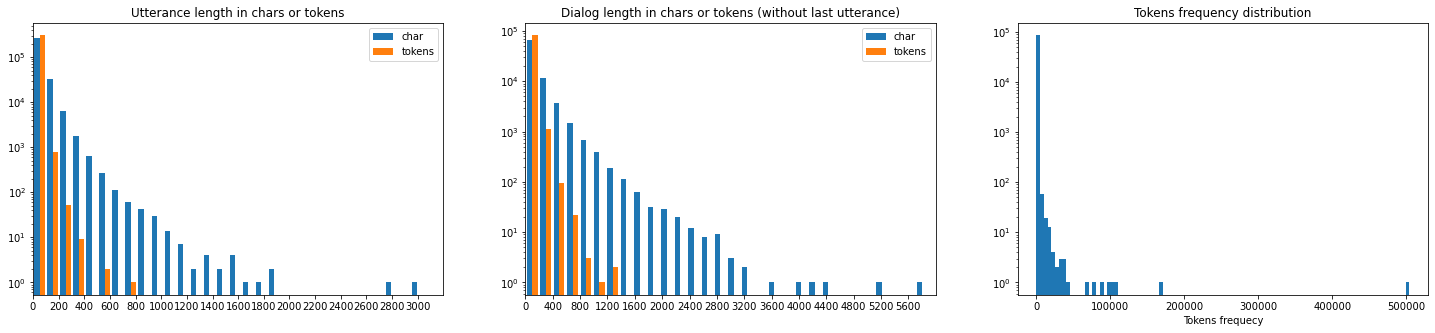

In [ ]:
plt.figure(figsize=(25, 5))
plt.subplot(1,3,1) # left plot
x1, x2 = zip(*utterance_length_list)
plt.hist([x1, x2], bins=30, label=['char', 'tokens'])
plt.title('Utterance length in chars or tokens')
plt.legend()
plt.yscale('log')
plt.xticks(np.arange(0, 3200, step=200))
plt.xlim(0,3200)

plt.subplot(1,3,2) # right plot
x1, x2 = zip(*dialog_length_list)
plt.hist([x1, x2], bins=30, label=['char', 'tokens'])
plt.title('Dialog length in chars or tokens (without last utterance)')
plt.legend()
plt.yscale('log')
plt.xticks(np.arange(0, 6000, step=400))
plt.xlim(0,6000)

plt.subplot(1, 3, 3)
plt.hist(vocab_freq.values(), bins=100,log=True)
plt.title('Tokens frequency distribution')
plt.xlabel('Tokens frequecy')
plt.show()
del x1; del x2

**Выводы EDA**:
- количество диалогов - 83 097, половина из них содержит 2-3 высказывания, хотя есть и длинные диалоги (максимум 89 высказываний)
- общее количество высказываний в файле - 304 713, из них 265 774 уникальных высказываний; также проверено, что все высказывания из 304 713 в файле используются в диалогах
- общее количество токенов во всех диалогах - 4 034 134 (из них 828 602 токена - это знаки препинания)
- всего 85 259 уникальных токенов (включая знаки препинания), из них половина (43,314 или 50.8%) встречаются лишь один раз.
- максимальная длина высказывания 3 046 символов или 730 токенов
- лишь незначительная часть высказываний длиннее 1 000 символов или 400 токенов

Если в качестве тренировочной последовательности (input_text) скармливать от 1 до N-1 высказываний, а следующее за ним/ними - выдавать за целевую, то:
- максимальная длина диалога на входе 5 899 символов или 1 366 токенов
- большая часть диалогов укладывается в 700-800 токенов или 2 000-2 500 символов


## Обзор вариантов модели чат-бота

*Выводы сделаны после того, как были реализованы все 3 модели.*<br>
*Во всех моделях LSTM слои Encoder'а двунаправленные, Decoder'а - однонаправленные.*

1. посимвольный Encoder-Decoder без attention (как в примере, финальные параметры: 3 слоя LSTM, H_SIZE=1024, EMB_SIZE=128 => 64,644,702 training parameters).

  Props:
  - значительно(!) меньше параметров на Embedding слое(-ях) и выходном Dense слое decoder'а.

  Cons:
  - сложнее архитектура сети: так как символ не содержит смысла всего слова, в котором он содержится, и это надо компенсировать бОльшей глубиной сети (2-3 слоя минимум, возможно с residual connections для борьбы с затухающим градиентом) и большим количеством фичей RNN слоев (несколько сотен или тысяч)
  - большая длина посимвольной последовательности: проблема градиентов и размер вычислительного графа - модель может просто не поместится в память GPU
  
  
2. Encoder-Decoder без attention на токенах. (финальные параметры: 2 слоя LSTM, H_SIZE=2048, EMB_SIZE=256 => 246,100,172 training parameters)
  
  Props:
  - на порядок короче длина цепочки
  - меньше внутренних слоев моделей
  - меньше затухания градиента из-за длины цепочек и меньшего количества слоев
  - всё это освобождает место для большего количества скрытых параметров: H_SIZE
  - возможность использовать специальные токены вроде `<NUM>` , `<PRICE>`, `<TIME>`, вместо которых можно подставлять сгенерированные значения (да и размер словарей это уменьшает) (это скорее вынужденная мера для уменьшения размера словарей и справедливости ради, то же самое можно было реализовать и для char-RNN)
  
  Cons:
  - больше обучаемых параметров (переобучение?)
  - в случае более сложных языков (с большим количеством форм слова) размер словарей увеличится многократно.
  
  
3. Encoder-Decoder с attention на токенах. (финальные параметры: 1 LSTM слой, H_SIZE=2048, EMB_SIZE=256, ATT_UNITS=2048 => 125,936,472 training parameters)

  Props (по сравнению с такой же моделью без attention):
  - Распределение внимания по словам для лучшего извлечения смысла предложения - количественно сложно сравнить, так как изначальные диалоги жестко вырваны из контекста, и ответы бота всё равно часто не в попад (особенно длинные ответы, в то время как короткие - более подходят предыдущей реплике)
  
  Cons:
  - значительное увеличение вычислительного графа при обучении и следовательно и ограничение на размер скрытых параметров, и/или длину цепочки (по сравнению со 2-ым вариантом максимальную длину цепочки пришлось уменьшить с 30 до 15 (одновременно уменьшая количество LSTM слоев с 2 до одного), чтоб вычислительный граф помещался в память GPU).
  - фиксированная длина входной цепочки.

Рассматриваемые варианты обучания:
- с максимальной длиной диалогов (не хватает памяти), приходится ограничивать число итераций на эпоху, так как слишком много долгие эпохи
- ограничивая длиной в 500 символов (не всегда хватает памяти в colab), продолжаем ограничивать число итераций на эпоху
- ограничивая длиной в 100 символов, всё еще остается около 100 000 диалогов в выборке, но теперь можно попробовать не ограничивать итерации и выполнять эпохи на всех данных
- обучение большими батчами (200-500) и минибатчами (менее 128)


## Вариант 1. Char-RNN Encoder-decoder without attention.

### Подготовка данных: input-target

Создадим списки из входных данных и соответствующих им целевых последовательностей.
Есть два варианта определения вход-выход:
1. Перебирая целевые высказывания от 2-го до последнего в диалоге, в качестве последовательности на входе берем предыдущее высказывание. Например, если далог состоит из 4 высказываний: `[a, b, c, d]` то пары input(I)-taget(T) будут:
  - I: `a`, T: `b`
  - I: `b`, T: `c`
  - I: `c`, T: `d`
2. Перебирая целевые высказывания от 2-го до последнего в диалоге, в качестве последовательности на входе берем все высказывания, идущие перед целевым.
Например, если далог состоит из 4 высказываний: `[a, b, c, d]` то пары input(I)-taget(T) будут:
  - I: `a`, T: `b`
  - I: `a b`, T: `c`
  - I: `a b c`, T: `d`

Для большей глубины мысли в encoder'е выберем 2-й вариант. Но при этом не будем использовать двунаправленную RNN чтоб важность последнего высказывания имело больший вес (как оно и будет происходить в однонаправленной сети).


In [ ]:
input_texts = []
target_texts = []
max_len_input, max_len_target = 0, 0
MAX_SEQ_LEN = 100

def prepare_text_for_charRNN(text):
    return re.sub(r'[ \t]+', " ", text).strip()

for dialog in tqdm(dialogs):
    for i in range(1, len(dialog)):
        # join (1 + ... + i-1) utterances in one input
        input_text = ' '.join([utterances[dialog[j]] for j in range(i)])
        # condition text
        input_text = prepare_text_for_charRNN(input_text) 
        # assign i-th utterance as target and condition it
        target_text = prepare_text_for_charRNN(utterances[dialog[i]])

        # stop processing this dialog if input or target max length is reached
        if max(len(input_text), len(target_text)) > MAX_SEQ_LEN:
            break
        
        max_len_input = max(max_len_input, len(input_text))
        max_len_target = max(max_len_target, len(target_text))
        input_texts.append(input_text)
        target_texts.append(target_text)

print('Length of input/target lists:', len(input_texts))
print('Max length of input:', max_len_input)
print('Max length of target:', max_len_target)

100%|██████████| 83097/83097 [00:01<00:00, 70444.74it/s]

Length of input/target lists: 99810
Max length of input: 100
Max length of target: 100


- 180550 elements with length <= 300
- 154803 elements with length <= 200
- 99810  elements with length <= **100**

In [ ]:
i = np.random.randint(0, high=len(input_texts))
print(f'Sample #{i}:')
print('-', input_texts[i])
print('-', target_texts[i])

Sample #72526:
- -- Could you?
- Never tried, 'til now. Joe, may I kiss you?


Даже выбрав диалоги с последовательностями меньше 500 символов длиной, осталось 202 826 тренировочных примера, что полностью обойти полными эпохами не получится (2sec на батч из 128 последовательностей -> 53 минуты на одну полную эпоху)

### Подготовка словаря

Для первого варианта решения, в качестве элемента последовательности будем использовать один символ (а не слово).

Подготовим два словаря (отображения индекса в символ и символа в индекс), и сделаем это для всех высказований из `input_texts` и `target_texts`.

Кроме того, нам понадобятся специальные токены для начала и конца цепочки, и паддинга (`<START>`, `<END>`, `<PAD>`).

In [ ]:
vocab = set()
for text in tqdm(input_texts + target_texts):
    vocab.update(set(''.join(text)))
vocab = sorted(vocab)
vocab.append('<START>')
vocab.append('<END>')
vocab.append('<PAD>')
VOCAB_SIZE = len(vocab)
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

print(f'Vocabulary size: {VOCAB_SIZE}')

100%|██████████| 199620/199620 [00:00<00:00, 449585.66it/s]

Vocabulary size: 94


### Подготовка обучающего датасета

Наша модель будет состоять из двух частей: `Encoder` и `Decoder`. Задача энкодера считать входную цепочку и получить её закодированное представление. А задача декодера по этому закодированному представлению получить выходную цепочку.

Декодер по сути является генератором текста, поэтому используется он аналогично тому, как мы это делали ранее с символьным генератором текста. Отличие только в том, что тут декодер будет получать начальное состояние из энкодера, а в качестве "начала" цепочки будет получать токен `<START>`.

И точно так же, как и в случае с генератором, для обучения декодера в качестве входа и целевого выхода будем использовать одну и ту же цепочку, но сдвинутую на один элемент во времени. В конце Декодер должен предсказать токен `<END>`.

Например, входом и выходом для декодера могут быть такие две цепочки из семи символов (начальный и конечный токен это один символ):

`<START>Привет` --> `Привет<END>`

Таким образом, для **обучения** `Encoder-Decoder` нам понадоятся три набора цепочек:
 - `encoder_input_seqs` - входы в Encoder
 - `decoder_input_seqs` - входы в Decoder
 - `decoder_target_seqs` - целевые выходы из Decoder (и всей модели Encoder-Decoder)

Сами цепочки будут являться последовательностями целочисленных индексов (полученных с помощью соответствующих словарей).


In [ ]:
%%time
input_texts_as_int = [[char2idx[c] for c in text] for text in input_texts]
target_texts_as_int = [[char2idx[c] for c in text] for text in target_texts]

encoder_input_seqs = [np.array(text).astype(np.int8) for text in input_texts_as_int]
decoder_input_seqs = []
decoder_target_seqs = []
for target_text in target_texts_as_int:
    decoder_input_seqs.append(np.array([char2idx['<START>']] + target_text).astype(np.int8))
    decoder_target_seqs.append(np.array(target_text + [char2idx['<END>']]).astype(np.int8))

CPU times: user 1.64 s, sys: 44 ms, total: 1.68 s
Wall time: 1.69 s


### Паддинг цепочек

Вспомним, что для обучения нам надо использовать батчи, которые состоят из цепочек одинаковой длины. А изначально длина цепочек (как входных, так и выходных) может быть произвольной. Поэтому нам необходимо сделать паддинг -- дополнить все цепочки до некоторой фиксированной длины с помощью символа `<PAD>`. В качестве длин будем брать фактическую максимальную длину последовательностей (отдельно для входных, отдельно для выходных). Напомню, что для тренировочных данных мы брали цепочки не блинее 500 символов. 

In [ ]:
max_enc_seq_length = max([len(seq) for seq in encoder_input_seqs])
max_dec_seq_length = max([len(seq) for seq in decoder_input_seqs])

encoder_input_seqs = tf.keras.preprocessing.sequence.pad_sequences(
    encoder_input_seqs,
    value=char2idx['<PAD>'],
    padding='post',
    maxlen=max_enc_seq_length).astype(np.int8)

decoder_input_seqs = tf.keras.preprocessing.sequence.pad_sequences(
    decoder_input_seqs,
    value=char2idx['<PAD>'],
    padding='post',
    maxlen=max_dec_seq_length).astype(np.int8)

decoder_target_seqs = tf.keras.preprocessing.sequence.pad_sequences(
    decoder_target_seqs,
    value=char2idx['<PAD>'],
    padding='post',
    maxlen=max_dec_seq_length).astype(np.int8)

In [ ]:
encoder_input_seqs.shape, decoder_input_seqs.shape, decoder_target_seqs.shape

((99810, 100), (99810, 101), (99810, 101))

### Создание модели

Для создания Encoder-Decoder модели воспользуемся смесью двух стилей: реализация моделей через собственный класс и функциональный API. 

Сами по себе Encoder и Decoder (по отдельности) удобно реализовать в виде кастомных классов (наследованных от `tf.keras.Model`), так как у них может быть какая-то сложная реализация. При этом у них будет общий Embedding.

В нашем случае Encoder будет состоять из двух LSTM слоей, который будет возвращать финальное состояние после прохода по всей цепочке. В качестве состояния нас интересует и вектор `h` и вектор состояния LSTM `c`. Для него нам понадобится дополнительный флаг `return_state=True`

В Декодере будет два LSTM и полносвязный слой для генерации финальных ответов (распределение вероятностей по символам). Для прямого распространения (`__call__`) кроме входной цепочки декодер будет получать состояние от энкодера (`init_state`) и будет передавать его в свой LSTM слоя в качестве начального состояния, а возвращать будет предсказанную выходную цепочку (той же длины, return_sequences=True) состояние этого LSTM.

После того, как мы отдельно построили Encoder и Decoder, надо соединить их в Encoder-Decoder. Но так как нам нужно создать несколько входов в модель (отдельно входная цепочка в энкодер, отдельно входная цепочка в декодер) очень удобно сделать это с помощью функционального API. Фходные узлы создаются с помощью `tf.keras.layers.Input`, а затем строим вычислительный граф, используя модели `encoder_model` и `decoder_model`.

Используем разные `Embedding` слои для encoder и decoder, несмотря на то, что язык общения в диалогах один и тотже, для encoder'а и decoder'а они по факту разные. Также на входе и encoder и decoder ставим `Masking` слой для "отрезания" паддингов (чтобы обратное распространение градиентов по паддингам не считалось).

Финальная модель -- `seq2seq`

In [ ]:
# попробовать раздельные Embedding слои большего разрешения

H_SIZE = 1024 # Размерность скрытого состояния LSTM
EMB_SIZE = 128 # размерность эмбеддингов (и для входных и для выходных цепочек)

class Encoder(tf.keras.Model):
    def __init__(self, is_bidirectional=False, dropout=0.0):
        super().__init__()
        self.masking = tf.keras.layers.Masking(mask_value=char2idx['<PAD>'])
        self.embed = tf.keras.layers.Embedding(VOCAB_SIZE, EMB_SIZE)
        self.lstm1 = tf.keras.layers.LSTM(H_SIZE, return_sequences=True, 
                                          return_state=True, dropout=dropout)
        self.lstm2 = tf.keras.layers.LSTM(H_SIZE, return_sequences=True, 
                                          return_state=True, dropout=dropout)
        self.lstm3 = tf.keras.layers.LSTM(H_SIZE, return_sequences=False, 
                                          return_state=True, dropout=dropout)
        self.add_layer = tf.keras.layers.Add()
        self.is_bidirectional = is_bidirectional

        # bidirectional mode is sum to return that same shape of H, C as for single dir.
        if self.is_bidirectional:
            self.lstm1 = tf.keras.layers.Bidirectional(self.lstm1, merge_mode='sum')
            self.lstm2 = tf.keras.layers.Bidirectional(self.lstm2, merge_mode='sum')
            self.lstm3 = tf.keras.layers.Bidirectional(self.lstm3, merge_mode='sum')       
        
    def call(self, x):
        out = self.masking(x)
        out = self.embed(out)

        if self.is_bidirectional:
            out1, h1_f, c1_f, h1_b, c1_b = self.lstm1(out)
            h1 = h1_f + h1_b
            c1 = c1_f + c1_b
            
            out2, h2_f, c2_f, h2_b, c2_b = self.lstm2(out1)
            h2 = h2_f + h2_b
            c2 = c2_f + c2_b
            
            out_sum = self.add_layer([out1, out2])
            
            out3, h3_f, c3_f, h3_b, c3_b = self.lstm3(out_sum)
            h3 = h3_f + h3_b
            c3 = c3_f + c3_b
            
        else:
            out1, h1, c1 = self.lstm1(out)
            out2, h2, c2 = self.lstm2(out1)
            out_sum = self.add_layer([out1, out2])
            _, h3, c3 = self.lstm3(out_sum)
            
        state = ((h1, c1), (h2, c2), (h3, c3))
        return state

    
class Decoder(tf.keras.Model):
    def __init__(self, dropout=0.0):
        super().__init__()
        self.masking = tf.keras.layers.Masking(mask_value=char2idx['<PAD>'])
        self.embed = tf.keras.layers.Embedding(VOCAB_SIZE, EMB_SIZE)
        self.lstm1 = tf.keras.layers.LSTM(H_SIZE, return_sequences=True, 
                                          return_state=True, dropout=dropout)
        self.lstm2 = tf.keras.layers.LSTM(H_SIZE, return_sequences=True, 
                                          return_state=True, dropout=dropout)
        self.lstm3 = tf.keras.layers.LSTM(H_SIZE, return_sequences=True, 
                                          return_state=True, dropout=dropout)
        self.fc = tf.keras.layers.Dense(VOCAB_SIZE, activation='softmax')
        self.add_layer = tf.keras.layers.Add()
        
    def call(self, x, init_state):
        out = self.masking(x)
        out = self.embed(out)
        out1, h1, c1 = self.lstm1(out, initial_state=init_state[0])
        out2, h2, c2 = self.lstm2(out1, initial_state=init_state[1])
        out_sum = self.add_layer([out1, out2]) # residual connection
        out, h3, c3 = self.lstm3(out_sum, initial_state=init_state[2])
        out = self.fc(out)
        state = ((h1, c1), (h2, c2), (h3, c3))
        return out, state

DROPOUT_RATE = 0.0
encoder_model = Encoder(is_bidirectional=True, dropout=DROPOUT_RATE)
decoder_model = Decoder(dropout=DROPOUT_RATE)

encoder_inputs = tf.keras.layers.Input(shape=(None,))
decoder_inputs = tf.keras.layers.Input(shape=(None,))

enc_state = encoder_model(encoder_inputs)
decoder_outputs, _ = decoder_model(decoder_inputs, enc_state)

seq2seq = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0005, clipnorm=5.0) # clip gradients to avoid g explosion
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

loss = tf.losses.SparseCategoricalCrossentropy()

seq2seq.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    root_folder + 'models/model-charRNN/checkpoint.hdf5',
    monitor='loss', save_weights_only=True)

seq2seq.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
encoder (Encoder)               (((None, 1024), (Non 43028224    input_1[0][0]                    
__________________________________________________________________________________________________
decoder (Decoder)               ((None, None, 94), ( 21616478    input_2[0][0]                    
Total params: 64,644,702
Trainable params: 64,644,702
Non-trainable params: 0
________________

### Обучение модели

In [ ]:
# change to True to continue training from checkpoint
# or save weights if checkpoint fails to do it
restore_saved_model = True

if restore_saved_model:
    seq2seq.load_weights(
        root_folder + 'models/model-charRNN/checkpoint.hdf5'
        )
    print('Weights restored.')

Weights restored.


In [ ]:
BATCH_SIZE = 64
EPOCHS = 1

# enter last epoch number completely finished
epochs_counter = 140

train_ds = tf.data.Dataset.from_tensor_slices(((encoder_input_seqs, decoder_input_seqs), decoder_target_seqs))
train_ds = train_ds.shuffle(encoder_input_seqs.shape[0]).repeat().batch(BATCH_SIZE)
# placing batch after repeat we concatenate last (potentially incomplete) batch 
# with data from the next repeat (or epoch)

In [ ]:
# данных настолько много, что в эпохе 3000+ итераций (больше часа на 1 эпоху)
steps_per_epoch = encoder_input_seqs.shape[0] // BATCH_SIZE

# seq2seq.fit([encoder_input_seqs, decoder_input_seqs], decoder_target_seqs,
#           batch_size=BATCH_SIZE,
#           epochs=EPOCHS+epochs_counter, initial_epoch=epochs_counter,
#           steps_per_epoch=steps_per_epoch, callbacks=[checkpoint])


seq2seq.fit(train_ds, epochs=EPOCHS + epochs_counter, 
            initial_epoch=epochs_counter, steps_per_epoch=steps_per_epoch, 
            callbacks=[checkpoint]) 

epochs_counter += EPOCHS

Epoch 141/141
1559/1559 [==============================] - 1011s 648ms/step - loss: 0.2103 - accuracy: 0.9317


In [ ]:
# run it if the last epoch showed greater loss than previous checkpoint
backup_model = True

if backup_model:
    seq2seq.save_weights(
        root_folder + 'models/model-charRNN/checkpoint.hdf5'
       )

### Функция для инференса

Запуск инференса для Encoder-Decoder состоит из последовательного применения энкодера и декодера. 

Сначала прогоняем входную цепочку через энкодер и получаем закодированное представление `state`.

А дальше применяем декодер в похожем режиме, как это было с генератором текста (только теперь передаём `state` в качестве начального состояния). В цикле постепенно генерируем выходную цепочку, подавая в декодер лишь один (текущий) символ и получая один предсказанный (следующий) символ. Начинаем с символа `<START>` и повторяем до тех пор, пока не получим символ `<END>` на выходе или не достигнем лимита по количеству символов в цепочке. Для определения того, какой символ предсказал декодер, просто воспользуемся  функцией `argmax` для выходного распределения (выхода FC слоя).

In [ ]:
def mix_states(state1, state2, weights=None):
    """
    Both states is expected to be a tuple of N tuples of pairs, where N is a 
    number of hidden RNN layers in encoder/decoder, and pairs are tuples of 
    hidden state (h, c) (for LSTM layer).
    If hidden state doesn't have memory state (like GRU), then 
    state is expected to be like this: (h, )
    default weights = [0.5, 0.5]. They're weights to mix state1 and state2 in
    its weigthed average.
    For example, two LSTM layers model should have state = ((h1, c1), (h2, c2))
    where h1,c1 - state of the 1st LSTM layer, h2,c2 - state of 2nd LSTM layer.
    """
    if weights is None:
        weights = [0.5, 0.5]
    dim1 = len(state1) # number of hidden layers
    out = []
    for i in range(dim1):
        layer_state = []
        for j in range(len(state1[i])):
            layer_state.append(
                weights[0] * state1[i][j] + weights[1] * state2[i][j]
            )
        out.append(tuple(layer_state))
    return tuple(out)


def seq2seq_inference(input_seq, state_init=None, weights=None):
    max_length = 100
    input_seq_cor = re.sub(r'[\n]', '', input_seq) # delete \n as it's not in vocab
    input_seq_cor = prepare_text_for_charRNN(input_seq_cor)
    input_seq_cor = np.array([[char2idx[i] for i in input_seq_cor]]).astype(np.int8)
    state = encoder_model(input_seq_cor)
    
    
    
    if state_init is not None:
        if weights is None:
            weights = [1, 0.3]
        state = mix_states(state, state_init, weights=weights)

    target_seq = np.array([[char2idx['<START>']]])

    decoded_sentence = ''
    while True:
        output_tokens, state = decoder_model(target_seq, state)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2char[sampled_token_index]

        if (sampled_char == '<END>' or
           len(decoded_sentence) > max_length):
            break
        if sampled_char == '<PAD>':
            sampled_char = ' '
            
        decoded_sentence += sampled_char
        target_seq = np.array([[sampled_token_index]])
    
    # if output is null run it again with slightly different (mixed) state
    if decoded_sentence == '':
        decoded_sentence, state = seq2seq_inference(input_seq[:np.random.randint(len(input_seq))], state)
        
    return decoded_sentence, state

*U (user), B(bot)*

**Initial model (3 layers, no connections)** (checkpoint.hdf5)

After 28 epochs (14000 iterations total)

  U: What is your name?<br>
  B: I don't know. I was thinking of that thing I want to do with you.

After 60 epochs (30000 iters):

U: What is your name?<br>
B: I don't know. I don't know what the hell is going on.

After 70 epochs:

U: What is your name?<br>
B: I don't know. I was just talking about the same thing.

Next 10 epochs showed that model fell into local minimum (RSMProp, LR=0.001, max_seq_len changed from 500 to 300 due to memory constrains)... On all checkpoints model tends to answer closely the same thing regardless of input.

**Adding resudual connection from lstm1 output to lstm3 input. Change optimizer from RSMProp to Adam. Training from scratch on 300-len sequences** (checkpoint2.hdf5)

after 10 epochs (200 batch_size):

U: are you stupid?<br>
B: I don't know. I want to see you and I want to see you.

After 28 epochs (128 batch_size):

U: are you stupid?<br>
B: I don't know. *(inf)

**Use bidirectional LSTM layers in encoder (mode='sum'). Reduce EMB_SIZE from 256 to 128, increase H_SIZE from 512 to 1024, reduce sequence_max_length from 300 to 100. Training on full dataset without limitting steps_per_epoch**

after 11 epochs (batch_size=128, 8569 training steps)

U: are you stupid?<br>
B: I don't know. I just want to see him.

after 21 epochs (batch_size=64, 24159 training steps)

U: are you stupid?<br>
B: [thua!!!

after 33 epochs (batch_size=64, 42867 training steps)

U: are you stupid?<br>
B: What do you mean?

after 43 epochs (batch_size=64, 58457 training steps)

U: are you stupid?<br>
B: -- You can't be --

after 73 epochs (105227 training steps, weighting states 50/50):

U: ya ne hochu s toboy obshat'sya.<br>
B: You want to go talk to me?<br>
U: Sure, I do.<br>
B: ! You can't be here on the phone right now!!?<br>
U: I'm in your head. Ha-ha-ha.<br>
B: UNm, BUT YOUM MONYSAGS IT'S BAVY TH MATH THIS CAUSE.<br>
U: yes, you are stupid. lol<br>
B: UNU!!!<br>
U: How old are you?<br>
B: He's not a copy of this stuff, Doc.

after 83 epochs (120817 training steps, weighting states 60/40 + random trim of input if output is null):

U: Hello, Machine.<br>
B: He was a lady. I got a little stranger than you.<br>
U: Who are you talking about. Answer me!<br>
B: nna!<br>
U: You are not talkative, aren't you?<br>
B: iguy, if you don't mind...sich.<br>
U: Silence is gold. you're cool.<br>
B: e--you got that right this morning, and the damn thing Systems call it.<br>
U: Is he cool?<br>
B: I don't know. I guess I just got to go. I'm sure Josh.<br>
U: Bye. See you around!<br>
B: I don't know. I guess I'll see you again.

after 130 epochs:

User: I will let you talk, guys!<br>
Bot1: I don't know. I don't know. I don't know. I just want to see all my ship. I am giving you later.<br>
Bot2: It was an accident.<br>
Bot1: It was a brakey one. I wanted to see what you must have gone.<br>
Bot2: I'll take that as a bowling.<br>
Bot1: Understood<br>
Bot2: please. Stay away from me.<br>
Bot1: No! It was a bad idea! How come you're not at people?<br>
Bot2: I'll take that as a contest pot.<br>
Bot1: For the very momories are everything.<br>
Bot2: I'll talk to you later.<br>
Bot1: Understand what happened to me.<br>
Bot2: Under the focushet office.

User: please. Stay away from me.<br>
Bot1: No. I want to see the sun.<br>
Bot2: What do you mean?<br>
Bot1: phburg coconut man. New Belled with the Rest.<br>
Bot2: No. I want to see the sun.<br>
Bot1: Ucked me.<br>
Bot2: pity my fingers and a rich man.<br>
Bot1: Un-friend. Come on, girls --<br>
Bot2: I'm sorry, I didn't mean to.<br>
Bot1: Uss me. I missed you to marry me.<br>
Bot2: I'll be right back.<br>
Bot1: Uc! Back to the money!<br>
Bot2: What are you doing here?

### Пример инференса

Попробуем инференс Seq2Seq модели на цепочках из нашего датасета.

In [ ]:
import time

In [ ]:
state = None
decoded_sentence = 'Hello. How are you?' # input('User: ')
print(f'User: {decoded_sentence}')
for i in range(2):
#     decoded_sentence = input('User: ')
    decoded_sentence, state = seq2seq_inference(decoded_sentence, state, weights=[0.7, 0.3])
    time.sleep(2)
    print('Bot1:', decoded_sentence)
    decoded_sentence, state = seq2seq_inference(decoded_sentence, state, weights=[0.9, 0.1])
    time.sleep(2)
    print('Bot2:', decoded_sentence)
    
    # reset state every 3rd cycle
    if (i % 3 == 0) and (i > 0):
        state = None

User: Hello. How are you?
Bot1: I don't know. I think I've found a habit story.
Bot2: Yeah, well, I've been around the bend a bit.
Bot1: Ymy'd? This payment --
Bot2: You don't have to tell me about the <u>bast</u> for the wedding.


## Вариант 2. Token-RNN Encoder-decoder without attention.

### Подготовка данных: input-target

Создадим списки из входных данных и соответствующих им целевых последовательностей.
Есть два варианта определения вход-выход:
1. Перебирая целевые высказывания от 2-го до последнего в диалоге, в качестве последовательности на входе берем предыдущее высказывание. Например, если далог состоит из 4 высказываний: `[a, b, c, d]` то пары input(I)-taget(T) будут:
  - I: `a`, T: `b`
  - I: `b`, T: `c`
  - I: `c`, T: `d`
2. Перебирая целевые высказывания от 2-го до последнего в диалоге, в качестве последовательности на входе берем все высказывания, идущие перед целевым.
Например, если далог состоит из 4 высказываний: `[a, b, c, d]` то пары input(I)-taget(T) будут:
  - I: `a`, T: `b`
  - I: `a b`, T: `c`
  - I: `a b c`, T: `d`

Для большей глубины мысли в encoder'е выберем 2-й вариант. Но при этом не будем использовать двунаправленную RNN чтоб важность последнего высказывания имело больший вес (как оно и будет происходить в однонаправленной сети).

Каждое высказывание подготавливаем для токенизации: числа заменяем на `<NUM>`, время на `<TIME>`, стоимость на `<PRICE>`, удаляем не пунктуационные знаки `&gt; &lt; &quot; * ~ | { } _ [ ]`, удаляем лишние пробелы.

In [ ]:
input_texts = []
target_texts = []
max_len_input, max_len_target = 0, 0
MAX_SEQ_LEN = 40

def prepare_string(s):
    """
    Prepair utterance for tokenization.
    """
    # separate punctuation
    s = s.lower()
    s = re.sub(r"([?.!,-])", r" \1 ", s)
    # remove special characters
    s = re.sub(r"(&gt;)|(&lt;)|(&quot;)|([\*~|{}_\[\]`])", '', s)
    # substitute '&' to 'and'
    s = re.sub(r'\s&\s', ' and ', s)
    s = re.sub(r"(?<=\s)'(?=[a-z])|^'(?=[a-z])", "", s) # remove ' at the beginning of the word
    s = re.sub(r"(<[A-Za-z]+>)|(</[A-Za-z]+>)", "", s) # remove html-style tags
    s = re.sub(r"(^\$[0-9]+)|([0-9]+\$)", ' <PRICE> ', s) # replace prices with <PRICE> like $5 or 10$
    s = re.sub(r'([0-9]{1,2}h)|([0-9]{1,2}:[0-9]{2})', ' <TIME> ', s) # time formats like 5h, 10:35 to <TIME>
    s = re.sub(r"(?<=[0-9])(['%])", r" \g<1>", s) # separate % and ' from numbers, like "007's" or "10%"
    s = re.sub(r"[0-9]+-?((th)|(nd)|(st)|(rd))", " <NUM> ", s) # 1st, 2nd, 3rd, 10th or 10-th replace with <NUM>
    s = re.sub(r"(?<=[0-9])([A-Za-z]+)", r' \g<1>', s) # separate units like 33mm 300W
    s = re.sub(r"(#[0-9]+)|([0-9]+)", ' <NUM> ', s) # replace numbers with <NUM>
    # repalace double spaces and \t with single space
    s = re.sub(r'[" "\t]+', " ", s).strip()

    return s


for dialog in tqdm(dialogs):
    for i in range(1, len(dialog)):
        # join (1 + ... + i-1) utterances in one input
        input_text = ' '.join([utterances[dialog[j]] for j in range(i)])
        # condition text
        input_text = prepare_string(input_text).split(' ')
        # assign i-th utterance as target and condition it
        target_text = prepare_string(utterances[dialog[i]]).split(' ')

        # stop processing this dialog if input or target max length is reached
        if max(len(input_text), len(target_text)) > MAX_SEQ_LEN:
            break
        
        max_len_input = max(max_len_input, len(input_text))
        max_len_target = max(max_len_target, len(target_text))

        # it was noticed that some utterances are empty, for example L474
        if (len(target_text) == 1) and (target_text[0] == ''):
            # skip empty lines
            continue
        if (len(input_text) == 1) and (input_text[0] == ''):
            # skip empty lines
            continue

        input_texts.append(input_text)
        target_texts.append(target_text)

print('Length of input/target lists:', len(input_texts))
print('Max length of input:', max_len_input)
print('Max length of target:', max_len_target)

100%|██████████| 83097/83097 [00:13<00:00, 5946.55it/s]

Length of input/target lists: 141700
Max length of input: 40
Max length of target: 40


Проведем небольшой анализ объема тренировочных данных с разной максимальной длиной последовательности токенов:
- MAX_SEQ_LEN=100 -> 196 239 samples
- MAX_SEQ_LEN=50 -> 158 139 samples
- MAX_SEQ_LEN=40 -> 141 700 samples
- MAX_SEQ_LEN=30 -> 118 473 samples
- MAX_SEQ_LEN=20 -> 84 186 samples

Чтобы избежать слишком большого объема тренировочных данных, ограничим максимальное количество токенов с высказываниях 40-ю. При этом количество диалогов чуть превышает объем тренировочных данных, используемых в Char-RNN, но это оправдано гораздо большим количеством различных токенов.

In [ ]:
# random sample from training set
i = np.random.randint(0, high=len(input_texts))
print(f'Sample #{i}:')
print('-', ' '.join(input_texts[i]))
print('-', ' '.join(target_texts[i]))

Sample #16688:
- the ah . . . the radio's out .
- what ?


### Подготовка словаря

Одно слово или знак препинания - один токен.

Для входа (input) и выхода (target) подготовим два словаря (отображения индекса в токен и токен в индекс), и сделаем это для всех высказований из `input_texts` и `target_texts`.

Кроме того, нам понадобятся специальные токены для начала и конца цепочки, паддинга и незнакомых слов: `<START>`, `<END>`, `<PAD>`, `<UNK>`.

In [ ]:
def prepare_vocab(texts, is_input=False):
    vocab = set()
    counter = Counter()
    for text in texts:
        # for input_texts with replace irrelevant tokens with <UNK>
        # token should start with letter or basic punctuation ?.,!-
        # if is_input:
        #     text = [s if re.match(r'^[A-Za-z?.,!-]', s) else '<UNK>'  for s in text]
        vocab.update(set(text))
        for token in text:
            counter[token] += 1
    # для target датасета добавим теги начала и конца последовательности
    if not is_input:
        vocab.add('<START>')
        vocab.add('<END>')
    
    vocab.add('<PAD>')
    vocab.add('<UNK>')
    
    # обязательно сортируем токены, так как set() не является упорядоченным типом данных, 
    # т.е. при разных запусках получим разные индексы
    vocab = sorted(vocab)
    
    vocab_size = len(vocab)
    token2idx = {u:i for i, u in enumerate(vocab)}
    idx2token = np.array(vocab)
    
    return vocab_size, token2idx, idx2token, counter


INPUT_VOCAB_SIZE, input_token2idx, input_idx2token, input_counter = prepare_vocab(input_texts, is_input=True)
TARGET_VOCAB_SIZE, target_token2idx, target_idx2token, target_counter = prepare_vocab(target_texts)

print(f'Input vocab size: {INPUT_VOCAB_SIZE}')
for i in range(2):
    rare_tokens = sum([1 for freq in input_counter.values() if freq == i+1])
    print(f'  Tokens with frequency {i+1}:  {rare_tokens} ({rare_tokens/INPUT_VOCAB_SIZE*100:.2f}%)')
print(f'Target vocab size: {TARGET_VOCAB_SIZE}')
for i in range(2):
    rare_tokens = sum([1 for freq in target_counter.values() if freq == i+1])
    print(f'  Tokens with frequency {i+1}:  {rare_tokens} ({rare_tokens/TARGET_VOCAB_SIZE*100:.2f}%)')

Input vocab size: 33725
  Tokens with frequency 1:  9339 (27.69%)
  Tokens with frequency 2:  5864 (17.39%)
Target vocab size: 34764
  Tokens with frequency 1:  15624 (44.94%)
  Tokens with frequency 2:  5275 (15.17%)


In [ ]:
del input_counter
del target_counter

В полном наборе данных было 85к уникальных токенов. В данной выборке количество одноразовых токенов хоть и снизилось (в том числе из-за подготовки текста), но их процент остался на прежнем уровне (около 50% на target_texts).

### Подготовка обучающего датасета

Наша модель будет состоять из двух частей: `Encoder` и `Decoder`. Задача энкодера считать входную цепочку и получить её закодированное представление. А задача декодера по этому закодированному представлению получить выходную цепочку.

Декодер по сути является генератором текста, поэтому используется он аналогично тому, как мы это делали ранее с символьным генератором текста. Отличие только в том, что тут декодер будет получать начальное состояние из энкодера, а в качестве "начала" цепочки будет получать токен `<START>`.

И точно так же, как и в случае с генератором, для обучения декодера в качестве входа и целевого выхода будем использовать одну и ту же цепочку, но сдвинутую на один элемент во времени. В конце Декодер должен предсказать токен `<END>`.

Например, входом и выходом для декодера могут быть такие две цепочки из семи символов (начальный и конечный токен это один символ):

`<START>Привет` --> `Привет<END>`

Таким образом, для **обучения** `Encoder-Decoder` нам понадобятся три набора цепочек:
 - `encoder_input_seqs` - входы в Encoder
 - `decoder_input_seqs` - входы в Decoder
 - `decoder_target_seqs` - целевые выходы из Decoder (и всей модели Encoder-Decoder)

Сами цепочки будут являться последовательностями целочисленных индексов (полученных с помощью соответствующих словарей).

In [ ]:
%%time
input_texts_as_int = [[input_token2idx.get(token, input_token2idx['<UNK>']) for token in text] for text in input_texts]
target_texts_as_int = [[target_token2idx.get(token, target_token2idx['<UNK>']) for token in text] for text in target_texts]

encoder_input_seqs = [np.array(text) for text in input_texts_as_int]
decoder_input_seqs = []
decoder_target_seqs = []
for target_text in target_texts_as_int:
    decoder_input_seqs.append(np.array([target_token2idx['<START>']] + target_text))
    decoder_target_seqs.append(np.array(target_text + [target_token2idx['<END>']]))

CPU times: user 1.65 s, sys: 44.1 ms, total: 1.69 s
Wall time: 1.69 s


### Паддинг цепочек

Вспомним, что для обучения нам надо использовать батчи, которые состоят из цепочек одинаковой длины. А изначально длина цепочек (как входных, так и выходных) может быть произвольной. Поэтому нам необходимо сделать паддинг -- дополнить все цепочки до некоторой фиксированной длины с помощью токена `<PAD>`. В качестве длин будем брать фактическую максимальную длину последовательностей (отдельно для входных, отдельно для выходных). Напомню, что для тренировочных данных мы брали цепочки не длинее 40 токенов. 

In [ ]:
max_enc_seq_length = max([len(seq) for seq in encoder_input_seqs])
max_dec_seq_length = max([len(seq) for seq in decoder_input_seqs])

encoder_input_seqs = tf.keras.preprocessing.sequence.pad_sequences(
    encoder_input_seqs,
    value=input_token2idx['<PAD>'],
    padding='post',
    maxlen=max_enc_seq_length)

decoder_input_seqs = tf.keras.preprocessing.sequence.pad_sequences(
    decoder_input_seqs,
    value=target_token2idx['<PAD>'],
    padding='post',
    maxlen=max_dec_seq_length)

decoder_target_seqs = tf.keras.preprocessing.sequence.pad_sequences(
    decoder_target_seqs,
    value=target_token2idx['<PAD>'],
    padding='post',
    maxlen=max_dec_seq_length)

### Создание модели

Для создания Encoder-Decoder модели воспользуемся смесью двух стилей: реализация моделей через собственный класс и функциональный API. 

Сами по себе Encoder и Decoder (по отдельности) удобно реализовать в виде кастомных классов (наследованных от `tf.keras.Model`), так как у них может быть какая-то сложная реализация.

В нашем случае Encoder будет состоять из двух LSTM слоей, который будет возвращать финальное состояние после прохода по всей цепочке. В качестве состояния нас интересует и вектор `h` и вектор состояния LSTM `c`. Для него нам понадобится дополнительный флаг `return_state=True`

В Декодере будет два LSTM и полносвязный слой для генерации финальных ответов (распределение вероятностей по символам). Для прямого распространения (`__call__`) кроме входной цепочки декодер будет получать состояние от энкодера (`init_state`) и будет передавать его в свой LSTM слоя в качестве начального состояния, а возвращать будет предсказанную выходную цепочку (той же длины, return_sequences=True) состояние этого LSTM.

После того, как мы отдельно построили Encoder и Decoder, надо соединить их в Encoder-Decoder. Но так как нам нужно создать несколько входов в модель (отдельно входная цепочка в энкодер, отдельно входная цепочка в декодер) очень удобно сделать это с помощью функционального API. Фходные узлы создаются с помощью `tf.keras.layers.Input`, а затем строим вычислительный граф, используя модели `encoder_model` и `decoder_model`.

Используем разные `Embedding` слои для encoder и decoder, несмотря на то, что язык общения в диалогах один и тотже, для encoder'а и decoder'а они по факту разные. Также на входе и encoder и decoder ставим `Masking` слой для "отрезания" паддингов (чтобы обратное распространение градиентов по паддингам не считалось).

Финальная модель -- `seq2seq`

In [ ]:
H_SIZE = 2048 # Размерность скрытого состояния LSTM
EMB_SIZE = 256 # размерность эмбеддингов (и для входных и для выходных цепочек)

class Encoder(tf.keras.Model):
    def __init__(self, is_bidirectional=False, dropout=0.0):
        super().__init__()
        self.masking = tf.keras.layers.Masking(mask_value=input_token2idx['<PAD>'])
        self.embed = tf.keras.layers.Embedding(INPUT_VOCAB_SIZE, EMB_SIZE)
        self.lstm1 = tf.keras.layers.LSTM(H_SIZE, return_sequences=True, 
                                          return_state=True, dropout=dropout)
        self.lstm2 = tf.keras.layers.LSTM(H_SIZE, return_sequences=False, 
                                          return_state=True, dropout=dropout)
        self.is_bidirectional = is_bidirectional

        # bidirectional mode is sum to return that same shape of H, C as for single dir.
        if self.is_bidirectional:
            self.lstm1 = tf.keras.layers.Bidirectional(self.lstm1, merge_mode='sum')
            self.lstm2 = tf.keras.layers.Bidirectional(self.lstm2, merge_mode='sum')
        
    def call(self, x):
        out = self.masking(x)
        out = self.embed(out)

        if self.is_bidirectional:
            out, h_f, c_f, h_b, c_b = self.lstm1(out)
            h1 = h_f + h_b
            c1 = c_f + c_b
            
            _, h_f, c_f, h_b, c_b = self.lstm2(out)
            h2 = h_f + h_b
            c2 = c_f + c_b
        else:
            out, h1, c1 = self.lstm1(out)
            _, h2, c2 = self.lstm2(out)

        state = ((h1, c1), (h2, c2))
        return state

class Decoder(tf.keras.Model):
    def __init__(self, dropout=0.0):
        super().__init__()
        self.masking = tf.keras.layers.Masking(mask_value=target_token2idx['<PAD>'])
        self.embed = tf.keras.layers.Embedding(TARGET_VOCAB_SIZE, EMB_SIZE)
        self.lstm1 = tf.keras.layers.LSTM(H_SIZE, return_sequences=True, 
                                          return_state=True, dropout=dropout)
        self.lstm2 = tf.keras.layers.LSTM(H_SIZE, return_sequences=True, 
                                          return_state=True, dropout=dropout)
        self.fc = tf.keras.layers.Dense(TARGET_VOCAB_SIZE, activation='softmax')
        
    def call(self, x, init_state):
        out = self.masking(x)
        out = self.embed(out)
        out, h1, c1 = self.lstm1(out, initial_state=init_state[0])
        out, h2, c2 = self.lstm2(out, initial_state=init_state[1])
        out = self.fc(out)
        state = ((h1, c1), (h2, c2))
        return out, state


encoder_model = Encoder(is_bidirectional=True)
decoder_model = Decoder(dropout=0.4)

encoder_inputs = tf.keras.layers.Input(shape=(None,))
decoder_inputs = tf.keras.layers.Input(shape=(None,))

enc_state = encoder_model(encoder_inputs)
decoder_outputs, _ = decoder_model(decoder_inputs, enc_state)

seq2seq = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

loss = tf.losses.SparseCategoricalCrossentropy()

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    root_folder + 'models/model-tokenRNN/checkpoint.hdf5',
    monitor='loss', save_weights_only=True)

seq2seq.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
seq2seq.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
encoder (Encoder)               (((None, 2048), (Non 113523968   input_1[0][0]                    
__________________________________________________________________________________________________
decoder (Decoder)               ((None, None, 34764) 132576204   input_2[0][0]                    
Total params: 246,100,172
Trainable params: 246,100,172
Non-trainable params: 0
______________

### Обучение модели

In [ ]:
BATCH_SIZE = 54
EPOCHS = 10
1

In [ ]:
# change to True to continue training from checkpoint
# or save weights if checkpoint fails to do it
restore_saved_model = True

if restore_saved_model:
    seq2seq.load_weights(
        root_folder + 'models/model-tokenRNN/checkpoint.hdf5'
        )
    print('weights are restored')

weights are restored


In [ ]:
EPOCHS = 6
epochs_counter = 34

In [ ]:
# данных настолько много, что в эпохе 3000+ итераций (больше часа на 1 эпоху)
steps_per_epoch = encoder_input_seqs.shape[0] // BATCH_SIZE

seq2seq.fit(train_ds, epochs=EPOCHS + epochs_counter, 
            initial_epoch=epochs_counter, steps_per_epoch=steps_per_epoch, 
            callbacks=[checkpoint]) 

epochs_counter += EPOCHS

Epoch 35/40
2624/2624 [==============================] - 2295s 875ms/step - loss: 0.6765 - accuracy: 0.8813
Epoch 36/40
2624/2624 [==============================] - 2290s 873ms/step - loss: 0.6672 - accuracy: 0.8833
Epoch 37/40
2624/2624 [==============================] - 2297s 875ms/step - loss: 0.6563 - accuracy: 0.8853
Epoch 38/40
2624/2624 [==============================] - 2329s 888ms/step - loss: 0.6473 - accuracy: 0.8872
Epoch 39/40
2624/2624 [==============================] - 2362s 900ms/step - loss: 0.6401 - accuracy: 0.8890
Epoch 40/40
2624/2624 [==============================] - 2347s 894ms/step - loss: 0.6382 - accuracy: 0.8897


In [ ]:
# run it if the last epoch showed greater loss than previous checkpoint
backup_model = True

if backup_model:
    seq2seq.save_weights(
        root_folder + 'models/model-tokenRNN/checkpoint.hdf5'
       )
    print('Weights saved.')

### Функция для инференса

Запуск инференса для Encoder-Decoder состоит из последовательного применения энкодера и декодера. 

Сначала прогоняем входную цепочку через энкодер и получаем закодированное представление `state`.

А дальше применяем декодер в похожем режиме, как это было с генератором текста (только теперь передаём `state` в качестве начального состояния). В цикле постепенно генерируем выходную цепочку, подавая в декодер лишь один (текущий) токен и получая один предсказанный (следующий) токен. Начинаем с токена `<START>` и повторяем до тех пор, пока не получим `<END>` на выходе или не достигнем лимита по количеству токенов в цепочке. Для определения того, какой токен предсказал декодер, просто воспользуемся  функцией `argmax` для выходного распределения (выхода FC слоя).

In [ ]:
def mix_states(state1, state2, weights=None):
    """
    Both states is expected to be a tuple of N tuples of pairs, where N is a 
    number of hidden RNN layers in encoder/decoder, and pairs are tuples of 
    hidden state (h, c) (for LSTM layer).
    If hidden state doesn't have memory state (like GRU), then 
    state is expected to be like this: (h, )
    default weights = [0.5, 0.5]. They're weights to mix state1 and state2 in
    its weigthed average.
    For example, two LSTM layers model should have state = ((h1, c1), (h2, c2))
    where h1,c1 - state of the 1st LSTM layer, h2,c2 - state of 2nd LSTM layer.
    """
    if weights is None:
        weights = [0.5, 0.5]
    dim1 = len(state1) # number of hidden layers
    out = []
    for i in range(dim1):
        layer_state = []
        for j in range(len(state1[i])):
            layer_state.append(
                weights[0] * state1[i][j] + weights[1] * state2[i][j]
            )
        out.append(tuple(layer_state))
    return tuple(out)


def generate_numbers(token):
    if token == '<NUM>':
        token = str(np.random.randint(100))
    elif token == '<TIME>':
        hours = np.random.randint(0, 12)
        minutes = np.random.randint(0, 60)
        token = f'{hours}:{minutes}'
        pass
    elif token == '<PRICE>':
        token = '$' + str(np.random.randint(100))

    return token

def seq2seq_inference(input_seq, state_init=None, weights=None):
    max_length = 40
    input_seq = re.sub(r'[\n]', '', input_seq) # delete \n as it's not in vocab
    input_seq = prepare_string(input_seq).split(' ')
    input_seq = np.array([[input_token2idx.get(token, input_token2idx['<UNK>']) for token in input_seq]])
    state = encoder_model(input_seq)
    
    if weights is None:
        weights=[0.8, 0.2]
        
    if state_init is not None:
        state = mix_states(state, state_init, weights=[0.8, 0.2])

    target_seq = np.array([[target_token2idx['<START>']]])

    decoded_sentence = []
    while True:
        output_tokens, state = decoder_model(target_seq, state)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = target_idx2token[sampled_token_index]

        if (sampled_token == '<END>' or
           len(decoded_sentence) > max_length):
            break
        sampled_token = generate_numbers(sampled_token)
        decoded_sentence.append(sampled_token)
        target_seq = np.array([[sampled_token_index]])
    
    s = " ".join(decoded_sentence) # join tokens in a string
    s = re.sub(r"\s([?.!,-])", r"\1", s).strip() # remove spaces before puctuation
    
    return s, state

In [ ]:
decoded_sentence, state = seq2seq_inference("How do you feel?")
print(decoded_sentence)
decoded_sentence, state = seq2seq_inference("Good afternoon, mister.")
print(decoded_sentence)

i don't know. what do we have to do?
oh my god, sir!


In [ ]:
# two bots talking...

state = None
weights = [0.9, 0.1]

dialog = ["Tell me a joke."]
print(f'User: {dialog[0]}')
for seq_index in range(0, 4):
    length = len(dialog)
    
    decoded_sentence, state = seq2seq_inference(" ".join(dialog[-min(4, length):]), state, weights)
    print(f'Bot1: {decoded_sentence}')
    dialog.append(decoded_sentence)
    length += 1
    
    decoded_sentence, state = seq2seq_inference(" ".join(dialog[-min(4, length):]), state, weights)
    print(f'Bot2: {decoded_sentence}')
    dialog.append(decoded_sentence)
    length += 1

User: Tell me a joke.
Bot1: there are so many questions.
Bot2: who are they? what do you expect from me-
Bot1: dear nothing in the world you haven't been before. you were saying anything morning--
Bot2: yes three- thirty. i used to love this little man.
Bot1: seven--
Bot2: bullshit.
Bot1: it's been over. have to get back to the hotel.
Bot2: maybe two million dollars for each?


In [ ]:
# chat with bot...

state = None
weights = [1, 0]

dialog = []
length = 0
for seq_index in range(0, 5):
    
    message = input('User: ')
    dialog.append(message)
    length += 1
    
    message, state = seq2seq_inference(" ".join(dialog[-min(4, length):]), state, weights)
    print(f'Bot1: {message}')
    dialog.append(message)
    length += 1

User: Hello there. My name is Tom. Who are you?
Bot1: it's my first friend.
User: What is your name?
Bot1: admiral.
User: Where are you from?
Bot1: , harry.
User: How old are you?
Bot1: i'm just trying to help.
User: Are you OK?
Bot1: i am, too.


After 34 epochs (about 140-150k training steps, I had to reduce batch_size from 64 to 60 and then to 54 due to memory contrains):

User: Why can't we be friends.<br>
Bot1: why?<br>
Bot2: i know all about it.<br>
Bot1: ... well, you know, you know, i know, i mean, what do you want?<br>
Bot2: like to know what i'm talking about.<br>
Bot1: huh?<br>
Bot2: no, i don't.<br>
Bot1: huh... sure.<br>
Bot2: get a drink. just tell them if you're right.<br>

User: Hello there. My name is Tom. Who are you?<br>
Bot1: it's me.<br>
User: your name?<br>
Bot1: ahh... do you want to come in?<br>
User: I'm already here. Who are you?<br>
Bot1: i came here to shut up.<br>
User: ha-ha-ha. So go ahead and shut up!<br>
Bot1: of course. there is one thing-- but there is no whole dead.<br>
User: you scary me...<br>
Bot1: inside? with what? there's nothing to talk about.

After 40 epochs:

User: Why can't we be friends?<br>
Bot1: i don't know.<br>
Bot2: i don't think that's a good idea.<br>
Bot1: bullshit.<br>
Bot2: holy. what do you mean?<br>
Bot1: put me down.<br>
Bot2: you do?<br>
Bot1: what?<br>
Bot2: what do you mean?<br>



## Вариант 3. Token-RNN Encoder-Decoder with Attention.

Вся подготовка данных, включая паддинг, аналогична Варианту 2. Различия начинаются с модели.

### Подготовка данных: input-target

Создадим списки из входных данных и соответствующих им целевых последовательностей.
Есть два варианта определения вход-выход:
1. Перебирая целевые высказывания от 2-го до последнего в диалоге, в качестве последовательности на входе берем предыдущее высказывание. Например, если далог состоит из 4 высказываний: `[a, b, c, d]` то пары input(I)-taget(T) будут:
  - I: `a`, T: `b`
  - I: `b`, T: `c`
  - I: `c`, T: `d`
2. Перебирая целевые высказывания от 2-го до последнего в диалоге, в качестве последовательности на входе берем все высказывания, идущие перед целевым.
Например, если далог состоит из 4 высказываний: `[a, b, c, d]` то пары input(I)-taget(T) будут:
  - I: `a`, T: `b`
  - I: `a b`, T: `c`
  - I: `a b c`, T: `d`

Для большей глубины мысли в encoder'е выберем 2-й вариант. Но при этом не будем использовать двунаправленную RNN чтоб важность последнего высказывания имело больший вес (как оно и будет происходить в однонаправленной сети).

Каждое высказывание подготавливаем для токенизации: числа заменяем на `<NUM>`, время на `<TIME>`, стоимость на `<PRICE>`, удаляем не пунктуационные знаки `&gt; &lt; &quot; * ~ | { } _ [ ]`, удаляем лишние пробелы.


In [ ]:
input_texts = []
target_texts = []
max_len_input, max_len_target = 0, 0
MAX_SEQ_LEN = 15

def prepare_string(s):
    """
    Prepair utterance for tokenization.
    """
    # separate punctuation
    s = s.lower()
    s = re.sub(r"([?.!,-])", r" \1 ", s)
    # remove special characters
    s = re.sub(r"(&gt;)|(&lt;)|(&quot;)|([\*~|{}_\[\]`])", '', s)
    # substitute '&' to 'and'
    s = re.sub(r'\s&\s', ' and ', s)
    s = re.sub(r"(?<=\s)'(?=[a-z])|^'(?=[a-z])", "", s) # remove ' at the beginning of the word
    s = re.sub(r"(<[A-Za-z]+>)|(</[A-Za-z]+>)", "", s) # remove html-style tags
    s = re.sub(r"(^\$[0-9]+)|([0-9]+\$)", ' <PRICE> ', s) # replace prices with <PRICE> like $5 or 10$
    s = re.sub(r'([0-9]{1,2}h)|([0-9]{1,2}:[0-9]{2})', ' <TIME> ', s) # time formats like 5h, 10:35 to <TIME>
    s = re.sub(r"(?<=[0-9])(['%])", r" \g<1>", s) # separate % and ' from numbers, like "007's" or "10%"
    s = re.sub(r"[0-9]+-?((th)|(nd)|(st)|(rd))", " <NUM> ", s) # 1st, 2nd, 3rd, 10th or 10-th replace with <NUM>
    s = re.sub(r"(?<=[0-9])([A-Za-z]+)", r' \g<1>', s) # separate units like 33mm 300W
    s = re.sub(r"(#[0-9]+)|([0-9]+)", ' <NUM> ', s) # replace numbers with <NUM>
    # repalace double spaces and \t with single space
    s = re.sub(r'[" "\t]+', " ", s).strip()

    return s


for dialog in tqdm(dialogs):
    for i in range(1, len(dialog)):
        # join (1 + ... + i-1) utterances in one input
        input_text = ' '.join([utterances[dialog[j]] for j in range(i)])
        # condition text
        input_text = prepare_string(input_text).split(' ')
        # assign i-th utterance as target and condition it
        target_text = prepare_string(utterances[dialog[i]]).split(' ')

        # stop processing this dialog if input or target max length is reached
        if max(len(input_text), len(target_text)) > MAX_SEQ_LEN:
            break
        
        max_len_input = max(max_len_input, len(input_text))
        max_len_target = max(max_len_target, len(target_text))

        # it was noticed that some utterances are empty, for example L474
        if (len(target_text) == 1) and (target_text[0] == ''):
            # skip empty lines
            continue
        if (len(input_text) == 1) and (input_text[0] == ''):
            # skip empty lines
            continue

        input_texts.append(input_text)
        target_texts.append(target_text)

print('Length of input/target lists:', len(input_texts))
print('Max length of input:', max_len_input)
print('Max length of target:', max_len_target)

100%|██████████| 83097/83097 [00:08<00:00, 10122.58it/s]

Length of input/target lists: 61141
Max length of input: 15
Max length of target: 15


Проведем небольшой анализ объема тренировочных данных с разной максимальной длиной последовательности токенов:
- MAX_SEQ_LEN=100 -> 196 239 samples
- MAX_SEQ_LEN=50 -> 158 139 samples
- MAX_SEQ_LEN=40 -> 141 700 samples
- MAX_SEQ_LEN=30 -> 118 426 samples
- MAX_SEQ_LEN=25 -> 102 967 samples
- MAX_SEQ_LEN=20 -> 84 140 samples
- MAX_SEQ_LEN=15 -> 61 141 samples

Чтобы избежать слишком большого объема тренировочных данных, ограничим максимальное количество токенов с высказываниях 40-ю. При этом количество диалогов чуть превышает объем тренировочных данных, используемых в Char-RNN, но это оправдано гораздо большим количеством различных токенов.

In [ ]:
# random sample from training set
i = np.random.randint(0, high=len(input_texts))
print(f'Sample #{i}:')
print('-', ' '.join(input_texts[i]))
print('-', ' '.join(target_texts[i]))

Sample #24585:
- aye , he looks a right lurker .
- you're undressed . where are your clothes ?


### Подготовка словаря

Одно слово или знак препинания - один токен.

Для входа (input) и выхода (target) подготовим два словаря (отображения индекса в токен и токен в индекс), и сделаем это для всех высказований из `input_texts` и `target_texts`.

Кроме того, нам понадобятся специальные токены для начала и конца цепочки, и паддинга (`<START>`, `<END>`, `<PAD>`). Также из input_texts уберем нетекстовые токены (начинающиеся не с буквы, например: цифры, скобки, ковычки, теги и пр.), заменив их на `<UNK>`.

In [ ]:
def prepare_vocab(texts, is_input=False):
    vocab = set()
    counter = Counter()
    for text in texts:
        # for input_texts with replace irrelevant tokens with <UNK>
        # token should start with letter or basic punctuation ?.,!-
        # if is_input:
        #     text = [s if re.match(r'^[A-Za-z?.,!-]', s) else '<UNK>'  for s in text]
        vocab.update(set(text))
        for token in text:
            counter[token] += 1
    # для target датасета добавим теги начала и конца последовательности
    if not is_input:
        vocab.add('<START>')
        vocab.add('<END>')
    
    vocab.add('<PAD>')
    vocab.add('<UNK>')
    vocab = sorted(vocab)
    vocab_size = len(vocab)
    token2idx = {u:i for i, u in enumerate(vocab)}
    idx2token = np.array(vocab)
    return vocab_size, token2idx, idx2token, counter


INPUT_VOCAB_SIZE, input_token2idx, input_idx2token, input_counter = prepare_vocab(input_texts, True)
TARGET_VOCAB_SIZE, target_token2idx, target_idx2token, target_counter = prepare_vocab(target_texts)

print(f'Input vocab size: {INPUT_VOCAB_SIZE}')
for i in range(2):
    rare_tokens = sum([1 for freq in input_counter.values() if freq == i+1])
    text = f'  Tokens with frequency {i+1}:  {rare_tokens} ({rare_tokens/INPUT_VOCAB_SIZE*100:.2f}%)'
    print(text)
print(f'Target vocab size: {TARGET_VOCAB_SIZE}')
for i in range(2):
    rare_tokens = sum([1 for freq in target_counter.values() if freq == i+1])
    text = f'  Tokens with frequency {i+1}:  {rare_tokens} ({rare_tokens/TARGET_VOCAB_SIZE*100:.2f}%)'
    print(text)

Input vocab size: 17113
  Tokens with frequency 1:  7363 (43.03%)
  Tokens with frequency 2:  2969 (17.35%)
Target vocab size: 17239
  Tokens with frequency 1:  8806 (51.08%)
  Tokens with frequency 2:  2661 (15.44%)


In [ ]:
del input_counter
del target_counter

В полном наборе данных было 85к уникальных токенов. В данной выборке количество одноразовых токенов хоть и снизилось (в том числе из-за подготовки текста), но их процент остался на прежнем уровне (около 50% на target_texts).

### Подготовка обучающего датасета

Наша модель будет состоять из двух частей: `Encoder` и `Decoder`. Задача энкодера считать входную цепочку и получить её закодированное представление. А задача декодера по этому закодированному представлению получить выходную цепочку.

Декодер по сути является генератором текста, поэтому используется он аналогично тому, как мы это делали ранее с символьным генератором текста. Отличие только в том, что тут декодер будет получать начальное состояние из энкодера, а в качестве "начала" цепочки будет получать токен `<START>`.

И точно так же, как и в случае с генератором, для обучения декодера в качестве входа и целевого выхода будем использовать одну и ту же цепочку, но сдвинутую на один элемент во времени. В конце Декодер должен предсказать токен `<END>`.

Например, входом и выходом для декодера могут быть такие две цепочки из семи символов (начальный и конечный токен это один символ):

`<START>Привет` --> `Привет<END>`

Таким образом, для **обучения** `Encoder-Decoder` нам понадобятся три набора цепочек:
 - `encoder_input_seqs` - входы в Encoder
 - `decoder_input_seqs` - входы в Decoder
 - `decoder_target_seqs` - целевые выходы из Decoder (и всей модели Encoder-Decoder)

Сами цепочки будут являться последовательностями целочисленных индексов (полученных с помощью соответствующих словарей).

In [ ]:
%%time
input_texts_as_int = [[input_token2idx.get(token, input_token2idx['<UNK>']) for token in text] for text in input_texts]
target_texts_as_int = [[target_token2idx.get(token, target_token2idx['<UNK>']) for token in text] for text in target_texts]

encoder_input_seqs = [np.array(text) for text in input_texts_as_int]
decoder_input_seqs = []
decoder_target_seqs = []
for target_text in target_texts_as_int:
    decoder_input_seqs.append(np.array([target_token2idx['<START>']] + target_text))
    decoder_target_seqs.append(np.array(target_text + [target_token2idx['<END>']]))

CPU times: user 508 ms, sys: 12 ms, total: 520 ms
Wall time: 518 ms


### Паддинг цепочек

Вспомним, что для обучения нам надо использовать батчи, которые состоят из цепочек одинаковой длины. А изначально длина цепочек (как входных, так и выходных) может быть произвольной. Поэтому нам необходимо сделать паддинг -- дополнить все цепочки до некоторой фиксированной длины с помощью символа `<PAD>`. В качестве длин будем брать фактическую максимальную длину последовательностей (отдельно для входных, отдельно для выходных). Напомню, что для тренировочных данных мы брали цепочки не блинее 500 символов. 

In [ ]:
max_enc_seq_length = max([len(seq) for seq in encoder_input_seqs])
max_dec_seq_length = max([len(seq) for seq in decoder_input_seqs])

encoder_input_seqs = tf.keras.preprocessing.sequence.pad_sequences(
    encoder_input_seqs,
    value=input_token2idx['<PAD>'],
    padding='post',
    maxlen=max_enc_seq_length)

# decoder_input_seqs = tf.keras.preprocessing.sequence.pad_sequences(
#     decoder_input_seqs,
#     value=target_token2idx['<PAD>'],
#     padding='post',
#     maxlen=max_dec_seq_length)

decoder_target_seqs = tf.keras.preprocessing.sequence.pad_sequences(
    decoder_target_seqs,
    value=target_token2idx['<PAD>'],
    padding='post',
    maxlen=max_dec_seq_length)

encoder_input_seqs.shape,  decoder_target_seqs.shape # decoder_input_seqs.shape,

((61141, 15), (61141, 16))

### Создание модели

Для создания Encoder-Decoder модели воспользуемся тремя классами: Encoder, Decoder (наследуемые от `tf.keras.Model`) и Attention (наследуемый от `tf.keras.layers.Layer`). 

Сами по себе Encoder и Decoder (по отдельности) удобно реализовать в виде кастомных классов (наследованных от `tf.keras.Model`), так как у них может быть какая-то сложная реализация.

В нашем случае Encoder будет состоять из двух LSTM слоей, который будет возвращать финальное состояние после прохода по всей цепочке. В качестве состояния нас интересует и вектор `h` и вектор состояния LSTM `c`. Для него нам понадобится дополнительный флаг `return_state=True`. В отличие от предыдущих моделей, будем возвращать также и полную цепочку с последнего LSTM слоя (return_sequences=True) для механизма Attention.

В Декодере будет два LSTM и полносвязный слой для генерации финальных ответов (распределение вероятностей по символам). 

В отличии от модели без Attention, предсказания будут делаться только по одному токену за раз, так как на вход слоя с Attention поступают выход енкодера и текущее состояние (будем использовать состояние `h` последнего LSTM слоя), которое изменяется после каждого предсказанного токена декодером. Важно отметить, что Attention содержит Dense слои, следовательно длина входной цепочки всегда **фиксирована** с момента инициализации (в нашем случае 40 токенов).

Для прямого распространения декодера (`__call__`) кроме входной цепочки декодер будет получать выхоную цепочку с енкодера, состояния слоев от энкодера (`init_state`) и будет передавать его в свои LSTM слои в качестве начального состояния, а возвращать будет предсказанный токен и новые состояния LSTM слоев. 

Используем разные `Embedding` слои для encoder и decoder, несмотря на то, что язык общения в диалогах один и тотже, для encoder'а и decoder'а они по факту разные. Также на входе encoder ставим `Masking` слой для "отрезания" паддингов (чтобы обратное распространение градиентов по паддингам не считалось). Но для decoder паддинг токены будем обрабатывать вручную (зануляя loss если ground truth token является паддингом).



In [ ]:
H_SIZE = 2048 # Размерность скрытого состояния LSTM
EMB_SIZE = 256 # размерность эмбеддингов (и для входных и для выходных цепочек)
ATT_UNITS = 2048 # attention units

class Encoder(tf.keras.Model):
    def __init__(self, is_bidirectional=False, dropout=0.0):
        super().__init__()
        self.masking = tf.keras.layers.Masking(mask_value=input_token2idx['<PAD>'])
        self.embed = tf.keras.layers.Embedding(INPUT_VOCAB_SIZE, EMB_SIZE)
        self.lstm1 = tf.keras.layers.LSTM(H_SIZE, return_sequences=True, 
                                          return_state=True, dropout=dropout)
#         self.lstm2 = tf.keras.layers.LSTM(H_SIZE, return_sequences=True, 
#                                           return_state=True, dropout=dropout)
        self.is_bidirectional = is_bidirectional

        # bidirectional mode is sum to return that same shape of H, C as for single dir.
        if self.is_bidirectional:
            self.lstm1 = tf.keras.layers.Bidirectional(self.lstm1, merge_mode='sum')
#             self.lstm2 = tf.keras.layers.Bidirectional(self.lstm2, merge_mode='sum')
        
    def call(self, x, init_state): # initial_state = hidden
        out = self.masking(x)
        out = self.embed(out)

        if self.is_bidirectional:
            out, h_f, c_f, h_b, c_b = self.lstm1(out, initial_state=init_state[0])
            h1 = h_f + h_b
            c1 = c_f + c_b
            
#             out, h_f, c_f, h_b, c_b = self.lstm2(out, initial_state=init_state[1])
#             h2 = h_f + h_b
#             c2 = c_f + c_b
        else:
            out, h1, c1 = self.lstm1(out, initial_state=init_state[0])
#             out, h2, c2 = self.lstm2(out, initial_state=init_state[1])

        state = ((h1, c1), ) #(h2, c2))
        return out, state
    
    def initialize_hidden_state(self, batch_sz, enc_units=H_SIZE):
        if self.is_bidirectional:
            # ((h1_f, c1_f, h1_b, c1_b),(h2_f, c2_f, h2_b, c2_b))
            return ((tf.zeros((batch_sz, enc_units)),
                    tf.zeros((batch_sz, enc_units)),
                    tf.zeros((batch_sz, enc_units)),
                    tf.zeros((batch_sz, enc_units))),)
#                    (tf.zeros((batch_sz, enc_units)),
#                     tf.zeros((batch_sz, enc_units)),
#                     tf.zeros((batch_sz, enc_units)),
#                     tf.zeros((batch_sz, enc_units))))
        else:
            # ((h1, c1), (h2, c2))
            return ((tf.zeros((batch_sz, enc_units)),
                    tf.zeros((batch_sz, enc_units))), )
#                   (tf.zeros((batch_sz, enc_units)),
#                     tf.zeros((batch_sz, enc_units))))

class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query hidden state (S_j-1) shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape (E_i) == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights


class Decoder(tf.keras.Model):
    def __init__(self, attention_units, dropout=0.0):
        super(Decoder, self).__init__()
        self.attention_units = attention_units
        self.masking = tf.keras.layers.Masking(mask_value=target_token2idx['<PAD>'])
        self.embed = tf.keras.layers.Embedding(TARGET_VOCAB_SIZE, EMB_SIZE)
        self.lstm1 = tf.keras.layers.LSTM(H_SIZE, return_sequences=True, 
                                          return_state=True, dropout=dropout)
#         self.lstm2 = tf.keras.layers.LSTM(H_SIZE, return_sequences=True, 
#                                           return_state=True, dropout=dropout)
        self.fc = tf.keras.layers.Dense(TARGET_VOCAB_SIZE) # without activation

        # used for attention
        self.attention = BahdanauAttention(self.attention_units)

    def call(self, x, init_state, enc_output):
        """
        Decoder with attention has to process 1 token at a time, so
        x.shape = (batch_size, 1, 1), i.e. 1 seq_len, 1 token's code
        """

        hidden = init_state[-1][0] # use last LSTM h-state for attention (e.g. h2)
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.masking(x)
        x = self.embed(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to LSTM layers
        out, h1, c1 = self.lstm1(x, initial_state=init_state[0])
#         out, h2, c2 = self.lstm2(out, initial_state=init_state[1])

        # out shape == (batch_size * 1, hidden_size)
        out = tf.reshape(out, (-1, out.shape[2]))

        # out shape == (batch_size, vocab)
        out = self.fc(out)
        state = ((h1, c1), ) # (h2, c2))
        return out, state, attention_weights

Напишем свою функцию потерь. В качестве основы возмем SparseCategoricalCrossentropy (из логитов и без нормирования loss'а по батчам - сделаем это в цикле обучения). Дополняем функцию потерь маской, зануляя loss для паддинг элеменов (из ground truth).

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none') # reduction done manually

def loss_function(real, pred):
  # mask to kill loss from <PAD> tokens in target ground truth
  mask = tf.math.logical_not(tf.math.equal(real, target_token2idx['<PAD>']))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

Создадим экземпляры классов, заодно проверим размерности всех входов/выходов.

In [ ]:
# use one batch of data as a sample during model creation
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices((encoder_input_seqs, decoder_target_seqs))
dataset = dataset.shuffle(encoder_input_seqs.shape[0]).batch(BATCH_SIZE)

example_input_batch, example_target_batch = next(iter(dataset))
print('Data sample shapes: input {}, target {}\n'.format(example_input_batch.shape, example_target_batch.shape))

# create instance of encoder
encoder = Encoder(is_bidirectional=True)

sample_hidden = encoder.initialize_hidden_state(batch_sz=BATCH_SIZE) # with default batch_size and h_size
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape (last LSTM): (batch size, units) {}'.format(sample_hidden[-1][0].shape))
print ('Encoder Hidden memory shape (last LSTM): (batch size, units) {}\n'.format(sample_hidden[-1][1].shape))

# create instance of Attention layer just to check its functionality
attention_layer = BahdanauAttention(ATT_UNITS)
# hidden state is h output of the last iteration on an input sequence from the second LSTM layer (e.g.: h2)
attention_result, attention_weights = attention_layer(sample_hidden[-1][0], sample_output)

print("Attention result shape: (batch size, hidden_size) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}\n".format(attention_weights.shape))

# create instance of decoder
decoder = Decoder(attention_units=ATT_UNITS, dropout=0.4)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Data sample shapes: input (64, 15), target (64, 16)

Encoder output shape: (batch size, sequence length, units) (64, 15, 2048)
Encoder Hidden state shape (last LSTM): (batch size, units) (64, 2048)
Encoder Hidden memory shape (last LSTM): (batch size, units) (64, 2048)

Attention result shape: (batch size, hidden_size) (64, 2048)
Attention weights shape: (batch_size, sequence_length, 1) (64, 15, 1)

Decoder output shape: (batch_size, vocab size) (64, 17239)


In [ ]:
encoder.summary()
decoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            multiple                  0         
_________________________________________________________________
embedding (Embedding)        multiple                  4380928   
_________________________________________________________________
bidirectional (Bidirectional multiple                  37765120  
Total params: 42,146,048
Trainable params: 42,146,048
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          multiple                  0         
_________________________________________________________________
embedding_1 (Embedding)      multiple                  4413184   
______________________________

Checkpoint (Object-based saving)

In [ ]:
del attention_layer

In [ ]:
# extra imports
import os
import time
from IPython.display import clear_output

# checkpoint
checkpoint_dir = root_folder + 'models/model-tokenRNN-Attention/'
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)
manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=1, checkpoint_name='ckpt')

### Обучение модели

Training steps ([tensorflow tutorial](https://www.tensorflow.org/tutorials/text/nmt_with_attention)):
1. Pass the input through the encoder which return encoder output and the encoder hidden state.
2. The encoder output, encoder hidden state and the decoder input (which is the start token) is passed to the decoder.
3. The decoder returns the predictions and the decoder hidden state.
4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
5. Use teacher forcing to decide the next input to the decoder.
6. Teacher forcing is the technique where the target word is passed as the next input to the decoder.
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.



In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden, metric):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([target_token2idx['<START>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(0, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions)

            # mask rows where target is <PAD> to exclude it from metrics
            mask = tf.math.logical_not(tf.math.equal(targ[:, t], target_token2idx['<PAD>']))
            metric.update_state(
                tf.boolean_mask(targ[:, t], mask), 
                tf.boolean_mask(predictions, mask)
            )

            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [ ]:
epochs_counter = 20

Основной цикл обучения модели. Для наглядности реализуем схожее отображение прогресса обучения, как у функции fit().

In [ ]:
EPOCHS = 20
steps_per_epoch = len(encoder_input_seqs)//BATCH_SIZE

# inits for progress bar
MAX_OUT = 30
epoch_digits = int(np.log10(steps_per_epoch)) + 1
buffer = []


def print_buffer(buffer):
    """Reprint buffer (static text of previous lines)."""
    clear_output(wait=True)
    for line in buffer:
        print(line, end='')


def progressbar_text(iteration, loss, time_passed, accuracy=None):
    """Print progress bar of current epoch with some statistics 
    like loss and ETA."""
    text = []
    if iteration == steps_per_epoch:
        # end of epoch text
        progress_bar = '=' * MAX_OUT
        iter_time_avg = time_passed / steps_per_epoch
        if iter_time_avg > 1:
            template = '{:.0f}s {:.0f}s/step'
        else:
            template = '{:.0f}s {:.0f}ms/step'
            iter_time_avg *= 1000
        text_time = template.format(time_passed, iter_time_avg)
    else:
        # in progress text
        frac = int(np.round((iteration/steps_per_epoch) * MAX_OUT))
        progress_bar = ('=' * (frac - 1)) + '>'  + '.' * (MAX_OUT - max(frac, 1))
        iter_time_avg = time_passed / (iteration + 1)
        est_time = int((steps_per_epoch - iteration - 1) * iter_time_avg)
        text_time = 'ETA: {}:{:0>2d}'.format(est_time // 60, est_time % 60)
    # prepare printout template with propper padding for itteration field
    template = '{' + f':>{epoch_digits}d' + '}/{} [{}]'
    text.append(template.format(iteration, steps_per_epoch, progress_bar))
    text.append(text_time)
    text.append('loss: {:.4f}'.format(loss))
    if accuracy is not None:
        text.append(f'accuracy: {float(accuracy):.4f}')
    return ' - '.join(text)


# main training cycle
metric = tf.keras.metrics.SparseCategoricalAccuracy()
metric_result = None

for epoch in range(epochs_counter, EPOCHS+epochs_counter):  
    buffer.append(f'Epoch {epoch+1}/{EPOCHS+epochs_counter}\n') # stdout

    enc_hidden = encoder.initialize_hidden_state(batch_sz=BATCH_SIZE)
    total_loss = 0

    start = time.time()
    previous_time = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        # batch training
        batch_loss = train_step(inp, targ, enc_hidden, metric)
        total_loss += batch_loss

        # print progress-bar not more frequently than 1 sec
        # to limit print/clear load if steps are too fast
        time_passed = time.time() - start
        if time_passed - previous_time > 1:
            previous_time = time_passed
            print_buffer(buffer)
            print(
                progressbar_text(batch, total_loss.numpy()/(batch+1), 
                                 time_passed, metric_result)
            )
        
        # refresh metric result every 20 iterations
        if (batch + 1) % 20 == 0:
            metric_result = metric.result()
    
    # save checkpoint
    manager.save()
    
    # append final epoch statistics to buffer
    buffer.append(
        progressbar_text(steps_per_epoch, total_loss / steps_per_epoch, 
                         time_passed, metric.result()) + '\n'
        )
    
    # reset metric at the end of epoch
    metric.reset_states()
    metric_result = None

print_buffer(buffer)

Epoch 21/40
955/955 [==============================] - 458s 479ms/step - loss: 0.2489 - accuracy: 0.8961
Epoch 22/40
955/955 [==============================] - 450s 471ms/step - loss: 0.2088 - accuracy: 0.9129
Epoch 23/40
955/955 [==============================] - 450s 471ms/step - loss: 0.1745 - accuracy: 0.9271
Epoch 24/40
955/955 [==============================] - 449s 470ms/step - loss: 0.1456 - accuracy: 0.9393
Epoch 25/40
955/955 [==============================] - 448s 469ms/step - loss: 0.1203 - accuracy: 0.9501
Epoch 26/40
955/955 [==============================] - 448s 469ms/step - loss: 0.0979 - accuracy: 0.9594
Epoch 27/40
955/955 [==============================] - 448s 469ms/step - loss: 0.0792 - accuracy: 0.9678
Epoch 28/40
955/955 [==============================] - 448s 469ms/step - loss: 0.0669 - accuracy: 0.9729
Epoch 29/40
955/955 [==============================] - 448s 469ms/step - loss: 0.0589 - accuracy: 0.9762
Epoch 30/40
955/955 [==============================] - 

In [ ]:
# save checkpoint
if True:
#     checkpoint.save(file_prefix = checkpoint_prefix)
    manager.save()

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
if True:
#     checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
    checkpoint.restore(manager.latest_checkpoint)

### Функция для инференса

In [ ]:
max_enc_seq_length

15

In [ ]:
def evaluate(sentence):
    attention_plot = np.zeros((max_dec_seq_length, max_enc_seq_length))
    
    input_seq = re.sub(r'[\n]', '', sentence) # delete \n as it's not in vocab
    input_seq = prepare_string(input_seq).split(' ')
    
    # take only last N tokens, where N is max_seq_length for encoder input
    if len(input_seq) > max_enc_seq_length:
        input_seq = input_seq[-max_enc_seq_length:]
        
    input_seq = np.array([[input_token2idx.get(token, input_token2idx['<UNK>']) for token in input_seq]])
    input_seq = tf.keras.preprocessing.sequence.pad_sequences(
                          input_seq,
                          value=input_token2idx['<PAD>'],
                          padding='post',
                          maxlen=max_enc_seq_length)   

    result = ''

    # hidden = [tf.zeros((1, units))]
    hidden = encoder.initialize_hidden_state(batch_sz=1) 
    enc_out, enc_hidden = encoder(input_seq, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([target_token2idx['<START>']], 0)
    # dec_input = tf.convert_to_tensor([[target_token2idx['<START>']]]) # equivalent option

    for t in range(max_dec_seq_length): # max_dec_seq_length or any other max length of output you want
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                            dec_hidden,
                                                            enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

#         predicted_id = tf.argmax(predictions[0]).numpy() # max_prob prediction
        temperature = 1.0
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1][0].numpy()

        if target_idx2token[predicted_id] == '<END>':
            break
#             return result #, sentence, attention_plot

        result += target_idx2token[predicted_id] + ' '

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)
    
    result = re.sub(r"\s([?.!,-])", r"\1", result).strip() # remove spaces before puctuation
    
    return result #, sentence, attention_plot

In [ ]:
# some test sentences
print(evaluate("Hey. Let's talk... Answer me!"))
print(evaluate("My name is John. What is your name?"))
print(evaluate("Hey. Let's talk"))
print(evaluate("It's a nice day."))
print(evaluate("How old are you?"))
print(evaluate("Hi"))
print(evaluate("What's up?"))
print(evaluate("is he with you? are you travelling together? yes."))
print(evaluate("i remember."))

poor guy's a bad guy...
viceroy of the west indies.
uh- huh. is that you had to get into something else?
yeah... no way, then.
eighteen.
alone-- bill!
what's it look like?
please join us. come on forward.
you'll be there, won't you.


In [ ]:
print(evaluate("Hi, Elena. How are you?"))

jogging. i was just sitting up for a minute.


after 40 epochs:

User: what are you doing?<br>
Bot1: are you my friend?<br>
Bot2: yes.<br>
Bot1: i am your friend.<br>
Bot2: you ain't nice.<br>
Bot1: maybe you wanted to fuck her. tomorrow friend.<br>
Bot2: sir?<br>
Bot1: just realized that, huh?<br>
Bot2: realize you got it to me.

User: How was your day, sir?<br>
Bot1: complicated. i couldn't stop her apologizing.<br>
Bot2: last year ago.<br>
Bot1: anyone got any family?<br>
Bot2: yes, he was.<br>
Bot1: mm- mm... my wife...<br>
Bot2: ... his majesty...<br>
Bot1: well, let's hit that party.<br>
Bot2: yes, but i think we should.

User: Hi. do you want to talk?<br>
Bot1: no.<br>
User: Bye<br>
Bot1: wanna go to dinner?<br>
User: why not. Let's do it!<br>
Bot1: thank god.<br>
User: You are welcome. Ha<br>
Bot1: daddy says i'm acting bad.<br>
User: I guess so.<br>
Bot1: but how did you do that?

In [ ]:
# two bots talking...

dialog = ["How was your day, sir?"]
print(f'User: {dialog[0]}')
for seq_index in range(0, 4):
    length = len(dialog)
    
    decoded_sentence = evaluate(" ".join(dialog[-min(4, length):]))
    print(f'Bot1: {decoded_sentence}')
    dialog.append(decoded_sentence)
    length += 1
    
    decoded_sentence = evaluate(" ".join(dialog[-min(4, length):]))
    print(f'Bot2: {decoded_sentence}')
    dialog.append(decoded_sentence)
    length += 1

User: How was your day, sir?
Bot1: complicated. i couldn't stop her apologizing.
Bot2: things have on the walls before she died.
Bot1: only common is all there.
Bot2: his secretary is saving the trip.
Bot1: just a minute. a few times i don't.
Bot2: just go to the old lady's over.
Bot1: i told ya i won't.
Bot2: well, look--


#### Сохраняем веса всех слоев

In [ ]:
!pwd

/home/kigor/Documents/DataScience


In [ ]:
base_dir = '/home/kigor/Documents/DataScience/TF_Serving/exports/'
enc_dir = base_dir + 'encoder/'
dec_dir = base_dir + 'decoder/'
vocab_dir = base_dir + 'vocabulary/'

Encoder

In [ ]:
encoder.layers

In [ ]:
enc_embed_w = encoder.layers[1].get_weights()
np.save(enc_dir + 'encoder_embed.npy', enc_embed_w[0])
print(enc_embed_w[0].shape)

(17113, 256)


In [ ]:
enc_lstm_w = encoder.layers[2].get_weights()
len(enc_lstm_w)
for i, weights in enumerate(enc_lstm_w):
    np.save(enc_dir + f'encoder_lstm_{i}.npy', weights)
    print(f'{i}: {weights.shape}')

0: (256, 8192)
1: (2048, 8192)
2: (8192,)
3: (256, 8192)
4: (2048, 8192)
5: (8192,)


Decoder

In [ ]:
decoder.layers

In [ ]:
dec_embed_w = decoder.layers[1].get_weights()
np.save(dec_dir + 'decoder_embed.npy', dec_embed_w[0])
print(dec_embed_w[0].shape)

(17239, 256)


In [ ]:
dec_lstm_w = decoder.layers[2].get_weights()
for i, weights in enumerate(dec_lstm_w):
    np.save(dec_dir + f'decoder_lstm_{i}.npy', weights)
    print(f'{i}: {weights.shape}')

0: (2304, 8192)
1: (2048, 8192)
2: (8192,)


In [ ]:
dec_fc_w = decoder.layers[3].get_weights()
for i, weights in enumerate(dec_fc_w):
    np.save(dec_dir + f'decoder_fc_{i}.npy', weights)
    print(f'{i}: {weights.shape}')

0: (2048, 17239)
1: (17239,)


In [ ]:
att_w1 = decoder.attention.W1.get_weights()
for i, weights in enumerate(att_w1):
    np.save(dec_dir + f'decoder_attW1_{i}.npy', weights)
    print(f'{i}: {weights.shape}')

0: (2048, 2048)
1: (2048,)


In [ ]:
att_w2 = decoder.attention.W2.get_weights()
for i, weights in enumerate(att_w2):
    np.save(dec_dir + f'decoder_attW2_{i}.npy', weights)
    print(f'{i}: {weights.shape}')

0: (2048, 2048)
1: (2048,)


In [ ]:
att_v = decoder.attention.V.get_weights()
for i, weights in enumerate(att_v):
    np.save(dec_dir + f'decoder_attV_{i}.npy', weights)
    print(f'{i}: {weights.shape}')

0: (2048, 1)
1: (1,)


Vocaburaries

In [ ]:
vocabs = [input_token2idx, target_token2idx, target_idx2token]
names = ['input_token2idx', 'target_token2idx', 'target_idx2token']
for name, vocab in zip(names, vocabs):
    np.save(vocab_dir + name + '.npy', vocab)